In [1]:
from google.colab import drive
drive.mount('../content/drive')

Mounted at ../content/drive


In [2]:
# library
import os
import glob
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

from torchvision import models
from torchsummary import summary
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from sklearn import preprocessing

In [3]:
# membuat csv file dari dataset (drive)

path = '../content/drive/My Drive/dataset/kendaraan/train/'

kend = {}
kend['nama'] = []
kend['tipe_kendaraan'] = []
kend['kondisi'] = []
for root, dirs, files in os.walk(path):
  for file in files:
    kend['nama'].append(os.path.join(file))
    tipe = os.path.join(root)
    kend['tipe_kendaraan'].append(tipe.split('/')[8])
    kend['kondisi'].append(tipe.split('/')[7])
print(kend)

{'nama': ['image.jpg', 'image2.jpg', 'image3.jpeg', 'image4.jpg', 'image5.jpg', 'image6.jpg', 'image7.jpg', 'image8.jpg', 'image9.jpg', 'image10.jpg', 'image11.jpg', 'image12.jpg', 'image13.jpg', 'image14.jpg', 'image15.jpg', 'image16.jpg', 'image17.jpg', 'image18.jpg', 'image19.jpg', 'image20.jpg', 'innova.jpg', 'crv.jpg', 'sedan.jpg', 'hitam.jpg', 'merah.jpg', 'mobilhitam.jpg', 'sedan2.jpg', 'suzuki.jpg', 'avanza.jpg', 'agya.jpg', 'alphard.jpg', 'sedan3.jpg', 'mobilputih.jpg', 'jeep.jpg', 'jeep2.jpg', 'sedan4.jpg', 'raize.jpg', 'sedan5.jpg', 'rush.jpeg', 'nissan.jpg', 'trukmerah.jpg', 'trukputih.jpg', 'trukkuning.jpg', 'trukbiru.jpg', 'trukijo.jpg', 'trukhijau.jpeg', 'putihtruk.jpg', 'ijoputih.png', 'birufull.jpeg', 'putihfull.jpg', 'kuningfull.jpg', 'birumerah.jpg', 'ijomerah.jpg', 'ijotruk.jpg', 'ijobiru.jpg', 'putihabu.jpg', 'merahfull.jpg', 'birutruk.jpg', 'biruputih.jpg', 'biruoren.jpeg', 'trukrusak1.jpg', 'trukrusak2.jpg', 'trukrusak3.jpg', 'trukrusak4.jpg', 'trukrusak5.jpeg', 

In [4]:


csv_file = "../content/drive/My Drive/dataset/kendaraan/train.csv"

kendaraan = pd.DataFrame.from_dict(kend)
kendaraan.head()

with open(csv_file, 'w') as f:
  kendaraan.to_csv(f)

### **Read CSV**

In [5]:
# read csv
train = pd.read_csv('../content/drive/My Drive/dataset/kendaraan/train.csv')
val = pd.read_csv('../content/drive/My Drive/dataset/kendaraan/val.csv')

train.head()

,Unnamed: 0,nama,tipe_kendaraan,kondisi
0,0,image.jpg,motor,kondisi_bagus
1,1,image2.jpg,motor,kondisi_bagus
2,2,image3.jpeg,motor,kondisi_bagus
3,3,image4.jpg,motor,kondisi_bagus
4,4,image5.jpg,motor,kondisi_bagus


### **Load dataset**

In [6]:
tipe_idx = {
    'mobil': 0,
    'motor': 1,
    'truk': 2
}
kondisi_idx = {
    'kondisi_bagus':0,
    'kondisi_rusak':1
}

idx_tipe = {
    0:'mobil',
    1:'motor',
    2:'truk'
}
idx_kondisi = {
    0:'kondisi_bagus',
    1:'kondisi_rusak'
}

In [7]:
# define dataset classes
class LoadDataset(Dataset):
  def __init__(self, df, im_paths, transform=None):
    self.im_paths = im_paths
    self.transform = transform
    self.df = df
        
  def __len__(self):
    return len(self.im_paths)
    
  def __getitem__(self, idx):
    image_filepath = self.im_paths[idx]
    image = Image.open(image_filepath).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)
      #image = torch.tensor(image, dtype=torch.float32)

    labela = self.df['tipe_kendaraan'][idx]
    tipe = tipe_idx[labela]
    tipe = torch.tensor(tipe, dtype=torch.long)

    labelb = self.df['kondisi'][idx]
    kondisi = kondisi_idx[labelb]
    kondisi = torch.tensor(kondisi, dtype=torch.long)

    list_of_labels = [torch.from_numpy(np.array(tipe)),
                      torch.from_numpy(np.array(kondisi))]
        
    return image, list_of_labels[0], list_of_labels[1]

In [8]:
data_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
path = '../content/drive/My Drive/dataset/kendaraan/'
im_path_train = path+'train/'+train['kondisi']+'/'+train['tipe_kendaraan']+'/'+train['nama']

train_ds = LoadDataset(train, im_path_train, data_transform)

In [9]:
im_path_val = path+'val/'+val['kondisi']+'/'+val['tipe_kendaraan']+'/'+val['nama']

val_ds = LoadDataset(val, im_path_val, data_transform)
val_ds

### **Build Model**

In [10]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.resnet34 = models.resnet34(pretrained=True)
    self.feature_extraction = nn.Sequential(
        self.resnet34.conv1,
        self.resnet34.bn1,
        self.resnet34.relu,
        self.resnet34.maxpool,
        self.resnet34.layer1,
        self.resnet34.layer2,
        self.resnet34.layer3,
        self.resnet34.layer4,
        self.resnet34.avgpool,
        )
    del self.resnet34

    self.l1_tipe = nn.Linear(512, 3)
    self.l2_kondisi = nn.Linear(512, 2)

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
      return num_features

  def forward(self, x):
    x = self.feature_extraction(x)
    x = x.view(-1, self.num_flat_features(x)) #flatten

    output1 = self.l1_tipe(x)
    output2 = self.l2_kondisi(x)

    return output1, output2

In [11]:
device = torch.device("cuda:0")
model = Model().to(device)

# learning parameters
lr = 0.001
opt = optim.Adam(params=model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
batch_size1 = 8
batch_size2 = 4
epochs = 100
best_acc = 0.0

dl_dict = {'train': torch.utils.data.DataLoader(train_ds, batch_size= batch_size1, shuffle=True),
           'val': torch.utils.data.DataLoader(val_ds, batch_size= batch_size2, shuffle=True)}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
# train dan evaluate model

for epoch in range(epochs):
  # train model
  train_loss = []
  print(f"Epoch {epoch+1} of {epochs}")
  model.train()
  
  with tqdm(dl_dict['train']) as train_dt:
    for inputs, tipe, kondisi in train_dt:
      inputs = inputs.to(device)
      tipe = tipe.to(device)
      kondisi = kondisi.to(device)

      out1, out2 = model(inputs)
      loss1 = loss_func(out1, tipe)
      loss2 = loss_func(out2, kondisi)

      loss = loss1+loss2
      train_loss.append(loss.item())

      loss.backward()
      opt.step()
      opt.zero_grad()

      train_dt.set_description('Progress')
      
  # evaluate model
  val_loss = []

  total1 = 0
  total2 = 0
  acc_tipe = 0
  acc_kondisi = 0
  model.eval()

  with tqdm(dl_dict['val']) as val_dt:
    for inputs, tipe, kondisi in val_dt:
      inputs = inputs.to(device)
      tipe = tipe.to(device)
      kondisi = kondisi.to(device)
      
      out1, out2 = model(inputs)
      loss1 = loss_func(out1, tipe)
      loss2 = loss_func(out2, kondisi)

      loss = loss1+loss2
      val_loss.append(loss.item())

      _, tipe_pred = torch.max(out1, 1)
      _, kondisi_pred = torch.max(out2, 1)

      total1 += tipe.size(0)
      acc_tipe += torch.sum(tipe_pred == tipe.data)

      total2 += kondisi.size(0)
      acc_kondisi += torch.sum(kondisi_pred == kondisi.data)

  mean_acc_tipe = 100*acc_tipe/total1
  mean_acc_kondisi = 100*acc_kondisi/total2

  mean_train_loss = np.mean(train_loss)
  mean_val_loss = np.mean(val_loss)

  total_acc = (mean_acc_tipe+mean_acc_kondisi)/2

  print("Train Loss: %.4f"%(mean_train_loss))
  print("Val Loss: %.4f"%(mean_val_loss))
  print("Akurasi: %.4f"%(total_acc))
  if total_acc > best_acc:
    best_acc = total_acc
    torch.save(model.state_dict(), "../content/drive/My Drive/dataset/kendaraan/multitask_weight.pth")
    print("Better validation, model saved")
  else:
    pass

Epoch 1 of 100


100%|██████████| 15/15 [00:40<00:00,  2.72s/it]


Train Loss: 1.8443
Val Loss: 46.5964
Akurasi: 43.3333
Better validation, model saved
Epoch 2 of 100


100%|██████████| 15/15 [00:01<00:00,  7.75it/s]


Train Loss: 1.5743
Val Loss: 7.8392
Akurasi: 49.1667
Better validation, model saved
Epoch 3 of 100


100%|██████████| 15/15 [00:01<00:00,  7.91it/s]


Train Loss: 1.0984
Val Loss: 1.8234
Akurasi: 62.5000
Better validation, model saved
Epoch 4 of 100


100%|██████████| 15/15 [00:01<00:00,  7.87it/s]


Train Loss: 0.8203
Val Loss: 2.0229
Akurasi: 63.3333
Better validation, model saved
Epoch 5 of 100


100%|██████████| 15/15 [00:02<00:00,  7.38it/s]


Train Loss: 0.6280
Val Loss: 1.5858
Akurasi: 62.5000
Epoch 6 of 100


100%|██████████| 15/15 [00:01<00:00,  7.93it/s]


Train Loss: 0.5583
Val Loss: 1.6312
Akurasi: 70.8333
Better validation, model saved
Epoch 7 of 100


100%|██████████| 15/15 [00:01<00:00,  8.00it/s]


Train Loss: 0.5747
Val Loss: 5.3086
Akurasi: 52.5000
Epoch 8 of 100


100%|██████████| 15/15 [00:02<00:00,  7.37it/s]


Train Loss: 0.6369
Val Loss: 2.9622
Akurasi: 59.1667
Epoch 9 of 100


100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


Train Loss: 0.5755
Val Loss: 1.8390
Akurasi: 68.3333
Epoch 10 of 100


100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


Train Loss: 0.5250
Val Loss: 1.4006
Akurasi: 75.8333
Better validation, model saved
Epoch 11 of 100


100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Train Loss: 0.2431
Val Loss: 1.0059
Akurasi: 80.0000
Better validation, model saved
Epoch 12 of 100


100%|██████████| 15/15 [00:01<00:00,  8.07it/s]


Train Loss: 0.2916
Val Loss: 1.7931
Akurasi: 75.8333
Epoch 13 of 100


100%|██████████| 15/15 [00:01<00:00,  8.03it/s]


Train Loss: 0.5134
Val Loss: 1.6337
Akurasi: 79.1667
Epoch 14 of 100


100%|██████████| 15/15 [00:01<00:00,  8.07it/s]


Train Loss: 0.4525
Val Loss: 3.2479
Akurasi: 57.5000
Epoch 15 of 100


100%|██████████| 15/15 [00:01<00:00,  8.20it/s]


Train Loss: 0.3638
Val Loss: 1.2978
Akurasi: 80.0000
Epoch 16 of 100


100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


Train Loss: 0.3104
Val Loss: 1.8529
Akurasi: 70.0000
Epoch 17 of 100


100%|██████████| 15/15 [00:01<00:00,  7.87it/s]


Train Loss: 0.1563
Val Loss: 0.8209
Akurasi: 83.3333
Better validation, model saved
Epoch 18 of 100


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


Train Loss: 0.4534
Val Loss: 2.0755
Akurasi: 74.1667
Epoch 19 of 100


100%|██████████| 15/15 [00:02<00:00,  7.23it/s]


Train Loss: 0.2454
Val Loss: 1.2182
Akurasi: 83.3333
Better validation, model saved
Epoch 20 of 100


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.4243
Val Loss: 2.6419
Akurasi: 59.1667
Epoch 21 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.2538
Val Loss: 1.8973
Akurasi: 77.5000
Epoch 22 of 100


100%|██████████| 15/15 [00:01<00:00,  7.85it/s]


Train Loss: 0.3213
Val Loss: 3.0121
Akurasi: 65.8333
Epoch 23 of 100


100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


Train Loss: 0.3940
Val Loss: 1.8180
Akurasi: 74.1667
Epoch 24 of 100


100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Train Loss: 0.5311
Val Loss: 2.6699
Akurasi: 65.8333
Epoch 25 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.2774
Val Loss: 2.3875
Akurasi: 66.6667
Epoch 26 of 100


100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


Train Loss: 0.2514
Val Loss: 2.0468
Akurasi: 67.5000
Epoch 27 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.2601
Val Loss: 1.0053
Akurasi: 80.0000
Epoch 28 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0868
Val Loss: 0.6207
Akurasi: 85.0000
Better validation, model saved
Epoch 29 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.0745
Val Loss: 0.6791
Akurasi: 86.6667
Better validation, model saved
Epoch 30 of 100


100%|██████████| 15/15 [00:02<00:00,  7.45it/s]


Train Loss: 0.0868
Val Loss: 0.9164
Akurasi: 82.5000
Epoch 31 of 100


100%|██████████| 15/15 [00:01<00:00,  7.84it/s]


Train Loss: 0.2317
Val Loss: 1.4702
Akurasi: 75.0000
Epoch 32 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.1456
Val Loss: 1.3100
Akurasi: 80.8333
Epoch 33 of 100


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.1923
Val Loss: 1.5444
Akurasi: 75.0000
Epoch 34 of 100


100%|██████████| 15/15 [00:01<00:00,  7.92it/s]


Train Loss: 0.1261
Val Loss: 1.0309
Akurasi: 83.3333
Epoch 35 of 100


100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


Train Loss: 0.2241
Val Loss: 0.8329
Akurasi: 89.1667
Better validation, model saved
Epoch 36 of 100


100%|██████████| 15/15 [00:01<00:00,  7.92it/s]


Train Loss: 0.2074
Val Loss: 0.9747
Akurasi: 82.5000
Epoch 37 of 100


100%|██████████| 15/15 [00:02<00:00,  7.22it/s]


Train Loss: 0.3113
Val Loss: 1.0717
Akurasi: 84.1667
Epoch 38 of 100


100%|██████████| 15/15 [00:01<00:00,  7.84it/s]


Train Loss: 0.1653
Val Loss: 1.0045
Akurasi: 83.3333
Epoch 39 of 100


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


Train Loss: 0.1074
Val Loss: 2.3776
Akurasi: 71.6667
Epoch 40 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.0797
Val Loss: 1.0164
Akurasi: 81.6667
Epoch 41 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0891
Val Loss: 0.7974
Akurasi: 83.3333
Epoch 42 of 100


100%|██████████| 15/15 [00:01<00:00,  7.75it/s]


Train Loss: 0.0664
Val Loss: 1.2467
Akurasi: 75.0000
Epoch 43 of 100


100%|██████████| 15/15 [00:01<00:00,  7.75it/s]


Train Loss: 0.0870
Val Loss: 1.2335
Akurasi: 77.5000
Epoch 44 of 100


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.1413
Val Loss: 1.2207
Akurasi: 80.0000
Epoch 45 of 100


100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


Train Loss: 0.3274
Val Loss: 3.0412
Akurasi: 68.3333
Epoch 46 of 100


100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


Train Loss: 0.1733
Val Loss: 0.9530
Akurasi: 82.5000
Epoch 47 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.1215
Val Loss: 1.0160
Akurasi: 81.6667
Epoch 48 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.1545
Val Loss: 1.5218
Akurasi: 78.3333
Epoch 49 of 100


100%|██████████| 15/15 [00:01<00:00,  7.73it/s]


Train Loss: 0.1838
Val Loss: 0.7984
Akurasi: 80.0000
Epoch 50 of 100


100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


Train Loss: 0.1571
Val Loss: 0.6641
Akurasi: 86.6667
Epoch 51 of 100


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.0972
Val Loss: 0.7747
Akurasi: 87.5000
Epoch 52 of 100


100%|██████████| 15/15 [00:01<00:00,  7.68it/s]


Train Loss: 0.0738
Val Loss: 1.1136
Akurasi: 83.3333
Epoch 53 of 100


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


Train Loss: 0.0850
Val Loss: 0.9481
Akurasi: 83.3333
Epoch 54 of 100


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


Train Loss: 0.1362
Val Loss: 0.9301
Akurasi: 86.6667
Epoch 55 of 100


100%|██████████| 15/15 [00:01<00:00,  7.90it/s]


Train Loss: 0.0397
Val Loss: 1.0074
Akurasi: 84.1667
Epoch 56 of 100


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


Train Loss: 0.0915
Val Loss: 0.8396
Akurasi: 85.8333
Epoch 57 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0871
Val Loss: 1.0749
Akurasi: 81.6667
Epoch 58 of 100


100%|██████████| 15/15 [00:01<00:00,  7.68it/s]


Train Loss: 0.0909
Val Loss: 1.0965
Akurasi: 79.1667
Epoch 59 of 100


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.0859
Val Loss: 0.8150
Akurasi: 89.1667
Epoch 60 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.0669
Val Loss: 1.1826
Akurasi: 85.0000
Epoch 61 of 100


100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


Train Loss: 0.0379
Val Loss: 0.8449
Akurasi: 90.8333
Better validation, model saved
Epoch 62 of 100


100%|██████████| 15/15 [00:01<00:00,  7.87it/s]


Train Loss: 0.0126
Val Loss: 0.9447
Akurasi: 87.5000
Epoch 63 of 100


100%|██████████| 15/15 [00:02<00:00,  7.21it/s]


Train Loss: 0.0231
Val Loss: 1.0244
Akurasi: 85.8333
Epoch 64 of 100


100%|██████████| 15/15 [00:01<00:00,  7.75it/s]


Train Loss: 0.0480
Val Loss: 1.2541
Akurasi: 85.0000
Epoch 65 of 100


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


Train Loss: 0.0584
Val Loss: 1.2055
Akurasi: 85.8333
Epoch 66 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.0151
Val Loss: 1.0277
Akurasi: 85.0000
Epoch 67 of 100


100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


Train Loss: 0.1195
Val Loss: 2.0450
Akurasi: 78.3333
Epoch 68 of 100


100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


Train Loss: 0.0703
Val Loss: 1.2760
Akurasi: 83.3333
Epoch 69 of 100


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.0859
Val Loss: 1.2209
Akurasi: 83.3333
Epoch 70 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0920
Val Loss: 1.0265
Akurasi: 85.0000
Epoch 71 of 100


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


Train Loss: 0.3421
Val Loss: 1.8646
Akurasi: 74.1667
Epoch 72 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.1211
Val Loss: 2.4798
Akurasi: 65.0000
Epoch 73 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.1167
Val Loss: 1.0375
Akurasi: 85.8333
Epoch 74 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.1461
Val Loss: 0.8409
Akurasi: 85.0000
Epoch 75 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.0291
Val Loss: 0.6411
Akurasi: 85.0000
Epoch 76 of 100


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.0124
Val Loss: 0.7215
Akurasi: 86.6667
Epoch 77 of 100


100%|██████████| 15/15 [00:01<00:00,  7.65it/s]


Train Loss: 0.0121
Val Loss: 1.0092
Akurasi: 85.8333
Epoch 78 of 100


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


Train Loss: 0.0303
Val Loss: 1.7227
Akurasi: 77.5000
Epoch 79 of 100


100%|██████████| 15/15 [00:01<00:00,  7.65it/s]


Train Loss: 0.0629
Val Loss: 1.9936
Akurasi: 70.8333
Epoch 80 of 100


100%|██████████| 15/15 [00:01<00:00,  7.64it/s]


Train Loss: 0.2896
Val Loss: 2.6820
Akurasi: 66.6667
Epoch 81 of 100


100%|██████████| 15/15 [00:01<00:00,  7.85it/s]


Train Loss: 0.1405
Val Loss: 1.8465
Akurasi: 75.8333
Epoch 82 of 100


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


Train Loss: 0.1612
Val Loss: 1.4848
Akurasi: 83.3333
Epoch 83 of 100


100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


Train Loss: 0.2010
Val Loss: 1.8665
Akurasi: 75.8333
Epoch 84 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.4223
Val Loss: 2.2770
Akurasi: 74.1667
Epoch 85 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.1068
Val Loss: 0.9535
Akurasi: 87.5000
Epoch 86 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.0975
Val Loss: 1.2109
Akurasi: 81.6667
Epoch 87 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.0489
Val Loss: 0.9257
Akurasi: 84.1667
Epoch 88 of 100


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.1246
Val Loss: 1.2119
Akurasi: 82.5000
Epoch 89 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.0733
Val Loss: 1.4389
Akurasi: 80.0000
Epoch 90 of 100


100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


Train Loss: 0.0519
Val Loss: 1.1220
Akurasi: 85.0000
Epoch 91 of 100


100%|██████████| 15/15 [00:01<00:00,  7.73it/s]


Train Loss: 0.0282
Val Loss: 1.0340
Akurasi: 86.6667
Epoch 92 of 100


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]


Train Loss: 0.0339
Val Loss: 1.0397
Akurasi: 84.1667
Epoch 93 of 100


100%|██████████| 15/15 [00:01<00:00,  7.74it/s]


Train Loss: 0.0154
Val Loss: 0.9775
Akurasi: 89.1667
Epoch 94 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0071
Val Loss: 1.0079
Akurasi: 88.3333
Epoch 95 of 100


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


Train Loss: 0.0053
Val Loss: 0.9759
Akurasi: 86.6667
Epoch 96 of 100


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Train Loss: 0.0061
Val Loss: 0.9443
Akurasi: 88.3333
Epoch 97 of 100


100%|██████████| 15/15 [00:01<00:00,  7.72it/s]


Train Loss: 0.0018
Val Loss: 0.9127
Akurasi: 88.3333
Epoch 98 of 100


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


Train Loss: 0.0120
Val Loss: 1.5337
Akurasi: 85.0000
Epoch 99 of 100


100%|██████████| 15/15 [00:01<00:00,  7.78it/s]


Train Loss: 0.0796
Val Loss: 1.0865
Akurasi: 81.6667
Epoch 100 of 100


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]

Train Loss: 0.0563
Val Loss: 0.9473
Akurasi: 84.1667


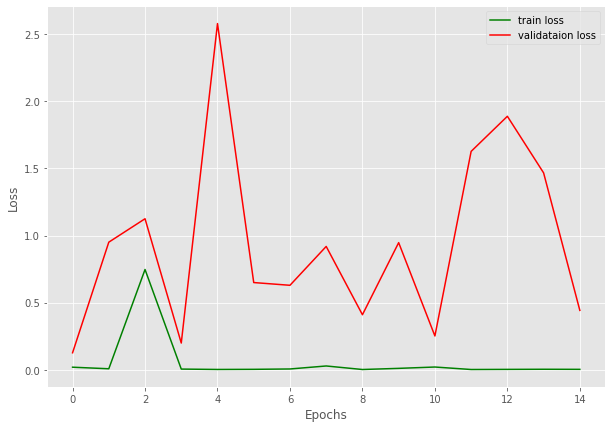

In [13]:
# plot train dan val loss
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='green', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../content/drive/My Drive/dataset/kendaraan/loss4.jpg')
plt.show()

In [14]:
# prediction inference
def predict(path):
  # read image transform to tensor
  image_open = Image.open(path)
  image = data_transform(image_open).float()
  image = torch.autograd.Variable(image, requires_grad=False)
  image = image.unsqueeze(0)

  # ngeload weight yg di cloud
  model = Model()
  model.load_state_dict(torch.load('../content/drive/My Drive/dataset/kendaraan/multitask_weight.pth', map_location='cpu'))
  model.eval()

  # masukin image datanya ke model
  with torch.no_grad():
    out1, out2 = model(image)

  # variabel output layer untuk para label
  out1 = F.softmax(out1, dim=1)
  out2 = F.softmax(out2, dim=1)
  #print(torch.max(out1, 1)[1].item())
  #print(torch.max(out2, 1)[1].item())

  # ambil prediksi maksimum dari suatu class sebagai output
  out1 = idx_tipe[torch.max(out1, 1)[1].item()]
  out2 = idx_kondisi[torch.max(out2, 1)[1].item()]

  # keluaran
  print('Prediction: ')
  print('Tipe Kendaraan: ',out1)
  print('Kondisi: ', out2)
  plt.imshow(image_open)

Prediction: 
Tipe Kendaraan:  mobil
Kondisi:  kondisi_rusak


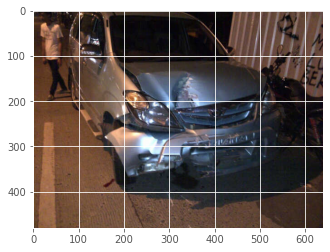

In [15]:
path = (r'../content/drive/My Drive/dataset/kendaraan/test/depi.jpg')
predict(path)

Prediction: 
Tipe Kendaraan:  motor
Kondisi:  kondisi_bagus


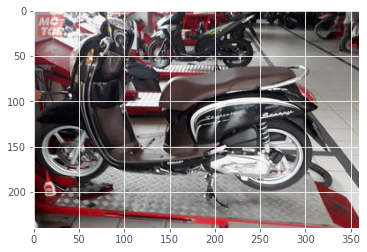

In [16]:
path = (r'../content/drive/My Drive/dataset/kendaraan/test/motobagus.jpg')
predict(path)

Prediction: 
Tipe Kendaraan:  truk
Kondisi:  kondisi_rusak


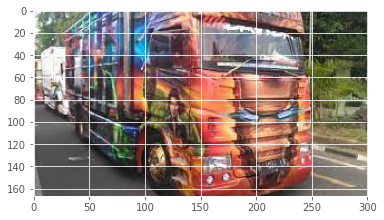

In [17]:
path = (r'../content/drive/My Drive/dataset/kendaraan/test/download.jpg')
predict(path)

Prediction: 
Tipe Kendaraan:  motor
Kondisi:  kondisi_rusak


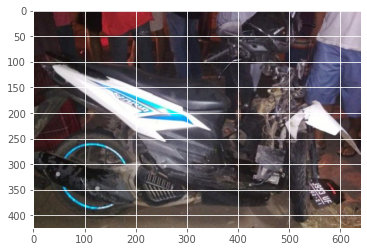

In [18]:
path = (r'../content/drive/My Drive/dataset/kendaraan/test/rusakkk.jpg')
predict(path)